# DQN с бинарным вектором

In [1]:
from snake_v0_ai import Game, RenderMode

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, ReLU
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

import random
import pickle
from collections import deque
from functools import partial
from IPython.display import clear_output
import tracemalloc as tm
import gc

import pygame

pygame 2.5.2 (SDL 2.28.2, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


2023-10-10 18:24:37.848251: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-10 18:24:37.907154: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-10 18:24:37.907224: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-10 18:24:37.907265: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-10 18:24:37.916219: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-10 18:24:39.969788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
gc.collect()

33

In [3]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 1e-2
GAMMA = 0.9

GAME_FIELD_SIZE = 14

STATE_VECTOR_SIZE = 11
WEIGHTS_DIRECTORY = "value_based/q/binary"

In [4]:
class Trainer:

    def __init__(self, model: Model, lr, gamma) -> None:
        self.lr = lr
        self.gamma = gamma
        optimizer = Adam(lr)
        model.compile(optimizer, "mse")
        self.model = model

    def train_step(self, states, actions, rewards, next_states, dones):
        pred = self.model(states).numpy()
        target = np.copy(pred)

        for i, done in enumerate(dones):
            q_new = rewards[i]
            if not done:
                q_new = rewards[i] + self.gamma * np.max(self.model(next_states[i][None, ...]).numpy())
                target[i][actions[i] + 1] = q_new

        self.model.fit(states, target, verbose=False)
                

In [5]:
class Agent:

    def __init__(self, model: Model, trainer: Trainer):
        self.n_games = 0
        self.epsilon = 0
        self.gamma = 0
        self.memory = deque(maxlen=MAX_MEMORY)
        self.model = model
        self.trainer = trainer
        self.stats = {
            "scores": [],
            "rewards": [],
        }

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(
            state[None, ...],
            np.array([action]),
            np.array([reward]),
            np.array([next_state]),
            np.array([done]),
        )

    def train_long_memory(self):        
        batch = random.sample(self.memory, BATCH_SIZE) \
            if len(self.memory) > BATCH_SIZE \
            else self.memory
        
        params = [np.array(param) for param in  zip(*batch)]
        
        self.trainer.train_step(*params)
                    
    def generate_action(self, state):
        self.epsilon = 100 - self.n_games

        if random.randint(0, 200) < self.epsilon:
            action = random.choice([-1, 0, 1])

        else:
            action = self.model(state[None, ...]).numpy()
            action = np.argmax(action) - 1
        
        return action
    
    def plot_statistics(self):
        fig, (lax, rax) = plt.subplots(1, 2, figsize=(15, 5))
        lax.plot(self.stats["scores"])
        lax.set_title(f"Scores")
        rax.plot(self.stats["rewards"])
        rax.set_title(f"Rewards")
        fig.suptitle(f"{self.n_games} games")
        plt.show()

    def backup(self):
        self.model.save_weights(f"{WEIGHTS_DIRECTORY}/{self.n_games}.keras")


In [10]:
model = Sequential([
    Input((STATE_VECTOR_SIZE, )),
    Flatten(),
    Dense(256, activation="relu"),
    # Dense(8, activation="relu"),
    Dense(3)
])

In [11]:
trainer = Trainer(model, LR, GAMMA)
agent = Agent(model, trainer)

In [12]:
env = Game(GAME_FIELD_SIZE, mode=RenderMode.BINARY_VECTOR, verbose=True)

In [6]:
env.reset()

(array([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0], dtype=int8),
 {'actions': {'Turn left': -1, 'Do nothing': 0, 'Turn right': 1},
  'modes': (['RGB_IMAGE',
    'GRAYSCALE_IMAGE',
    'GRAYSCALE_IMAGE_SHRINKED',
    'BINARY_VECTOR',
    'DISTANCED_VECTOR'],)})

In [13]:
env.step(0)

-0.7573593128807152 0.01


(array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0], dtype=int8),
 0.01,
 False,
 {'actions': {'Turn left': -1, 'Do nothing': 0, 'Turn right': 1},
  'modes': (['RGB_IMAGE',
    'GRAYSCALE_IMAGE',
    'GRAYSCALE_IMAGE_SHRINKED',
    'BINARY_VECTOR',
    'DISTANCED_VECTOR'],)})

In [ ]:
old_state, _ = env.reset()

for i in range(3):
    print(f"Iteration {i+1}")
    action = agent.generate_action(old_state)
    new_state, reward, done, _ = env.step(action)
    # if done: break

    new_state = state2vec(new_state)
    inf = (old_state.copy(), action, reward, new_state.copy(), done)
    agent.train_short_memory(*inf)
    agent.remember(*inf)
    old_state = new_state

if not done:
    agent.train_long_memory()


In [48]:
pygame.quit()

In [13]:
def start_epoch(agent: Agent):
    steps_without_apple = 0
    done = False
    old_state, info = env.reset()
    total_reward = 0
    
    while not done:
        steps_without_apple += 1
        action = agent.generate_action(old_state)
        new_state, reward, done, _ = env.step(action)

        if reward == 1:
            reward = 10
            steps_without_apple = 0

        elif reward == -1:
            reward = 0

        if steps_without_apple > 100:
            reward = -10
            break
        
        agent.train_short_memory(old_state, action, reward, new_state, done)
        agent.remember(old_state, action, reward, new_state, done)
        old_state = new_state

        total_reward += reward

    return env.score - 3, total_reward

In [16]:
def train(agent: Agent, epochs: int, display_frequency: int = 100, verbose: bool = True):
    
    for i in range(epochs):
        score, reward = start_epoch(agent)
        agent.n_games += 1
        agent.stats["scores"].append(score)
        agent.stats["rewards"].append(reward)
        agent.train_long_memory()
        clear_output(True)
        print(f"Epoch {i + 1}", end="\r")
        agent.plot_statistics()

        if (i + 1) % display_frequency == 0:
            agent.backup()

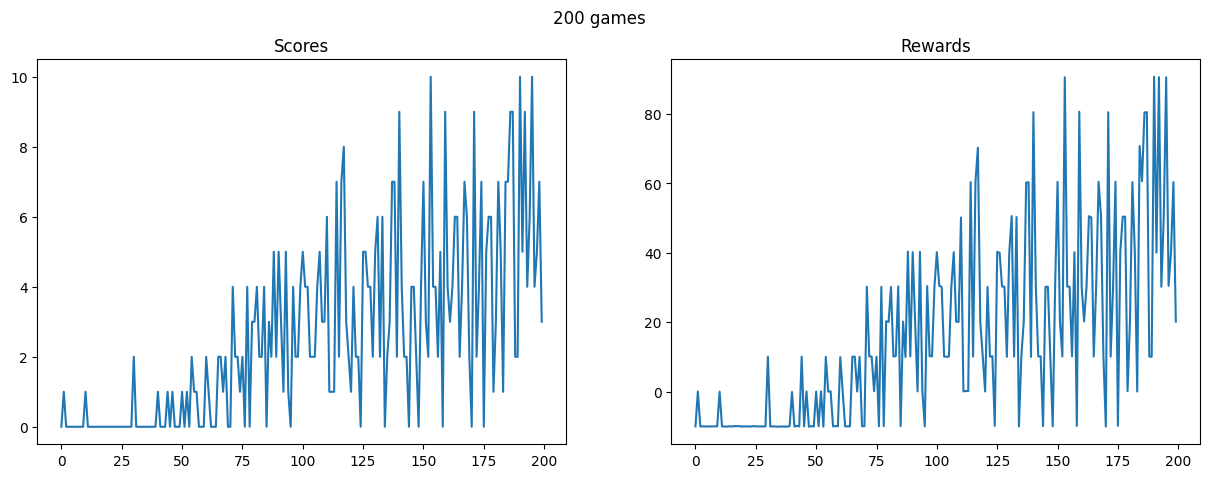

tm.get_traced_memory()=(178549315, 181005850)


In [17]:
train(agent, 200, 50)

### Ну так то лучшая из лучших, что сказать)